In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns

import os

import warnings
warnings.filterwarnings('ignore')

In [2]:
# Fonction pour réduire l'utilisation de la mémoire par le dataframe consolidé

def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type to reduce memory usage        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

In [3]:
# Import du dataframe consolidé et réduction de la taille de la mémoire

data_red = pd.read_csv("data_clean.csv", parse_dates=True, keep_date_col=True)
data_red = reduce_mem_usage(data_red)

Memory usage of dataframe is 535.45 MB
Memory usage after optimization is: 83.24 MB
Decreased by 84.5%


In [4]:
data_red.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 356255 entries, 0 to 356254
Columns: 197 entries, SK_ID_CURR to TARGET
dtypes: float16(31), float32(4), int16(2), int32(1), int8(159)
memory usage: 83.2 MB


In [5]:
# Chargement des modules

from sklearn.model_selection import train_test_split, KFold, cross_val_score, StratifiedKFold
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import confusion_matrix, make_scorer, accuracy_score, fbeta_score
from sklearn.metrics import precision_score, recall_score, roc_auc_score
from sklearn.dummy import DummyClassifier

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
import lightgbm as lgb
from sklearn.svm import SVC

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler, NearMiss 
from collections import Counter

import pickle 

plt.style.use('ggplot')

# Sommaire

[1. Préparation finale du dataset](#section1)  


[2. Définition d'un scoring adapté à problématique métier](#section2)
  
  
[3. Comparaison de plusieurs Classifiers et definition de fonctions](#section3)


[4. Optimization des performances - Logistic Regression ](#section4)

* [4.1 Rebalancing par le paramètre du classifier class_weight = 'balanced' ](#section4.1)
* [4.2 Rebalancing par oversampling de la classe minoritaire SMOTE](#section4.2)
* [4.3 Rebalancing par undersampling de la classe majoritaire](#section4.3)


[5. Optimization des performances - RandomForestClassifier ](#section5)

* [5.1 Rebalancing par le paramètre du classifier class_weight = 'balanced' ](#section5.1)
* [5.2 Rebalancing par oversampling de la classe minoritaire SMOTE](#section5.2)
* [5.3 Rebalancing par undersampling de la classe majoritaire](#section5.3)


[6. Optimization des performances - LGBM Classifier ](#section6)

* [6.1 Rebalancing par le paramètre du classifier class_weight = 'balanced' ](#section6.1)
* [6.2 Rebalancing par oversampling de la classe minoritaire SMOTE](#section6.2)
* [6.3 Rebalancing par undersampling de la classe majoritaire](#section6.3)
  

[7. Synthèse des résultats ](#section7)


[8. Interprétabilité du modèle](#section8)

* [8.1 Analyse globale du modèle: importance des variables](#section8.1)
* [8.2 Analyse locale du modèle: SHAP](#section8.2)


<a id="section1"> </a>
# 1. Préparation finale du dataset

In [6]:
# Conservation uniquement des données avec Target

data_red = data_red[data_red.train_test == 1]

In [7]:
# Suppression des variables faisant partie des paires corrélées telles qu'identifiées dans analyse explo

col_to_delete = ['AMT_CREDIT','REGION_RATING_CLIENT', 'OBS_60_CNT_SOCIAL_CIRCLE','DAYS_EMPLOYED']

data_red = data_red.drop(col_to_delete, axis = 1)

In [8]:
# Sampling aléatoire et séparation entre variables indépendantes et Target

data_sample = data_red.sample(15000, random_state=1)

X = data_sample.drop(columns = ['TARGET', 'SK_ID_CURR'])
Y = data_sample['TARGET']

In [9]:
# Split Train / Test en conservant les proportions de la variable cible (stratify = Y)

Xtrain, Xtest, ytrain, ytest = train_test_split(X, Y, train_size=0.75, random_state=2, stratify=Y)

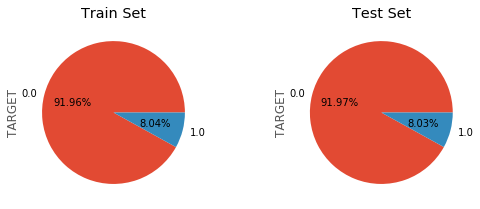

In [10]:
# Confirmation que les données sont déséquilibrées avec une sous-représentation de la variable Target = 1

fig, ax = plt.subplots(1,2, figsize=(8,4))
ytrain.value_counts().plot.pie(autopct='%1.2f%%', ax=ax[0], title='Train Set');
ytest.value_counts().plot.pie(autopct='%1.2f%%', ax=ax[1], title='Test Set');
fig.subplots_adjust(wspace=0.5);

In [11]:
# Scaling des variables Xtrain et Xtest

scaler = MinMaxScaler().fit(Xtrain)

Xtrain = pd.DataFrame(scaler.transform(Xtrain), index = Xtrain.index, columns = Xtrain.columns)
Xtest = pd.DataFrame(scaler.transform(Xtest), index = Xtest.index, columns = Xtest.columns)

Afin de voir si les données sont potentiellement séparables facilement, je vais utiliser une visualisation t-SNE des deux classes

In [12]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=np.random.randint(100))
matrix_2d = tsne.fit_transform(X)

In [13]:
# Préparation d'un DataFrame avec les données TSNE

colors = ['G' if i==0 else 'R' for i in Y]

df_tsne = pd.DataFrame(matrix_2d)
df_tsne['Class'] = pd.DataFrame(Y)["TARGET"].values
df_tsne['color'] = colors
df_tsne.columns = ['x','y','Class','color']
cols = ['Class','color','x','y']
df_tsne = df_tsne[cols]

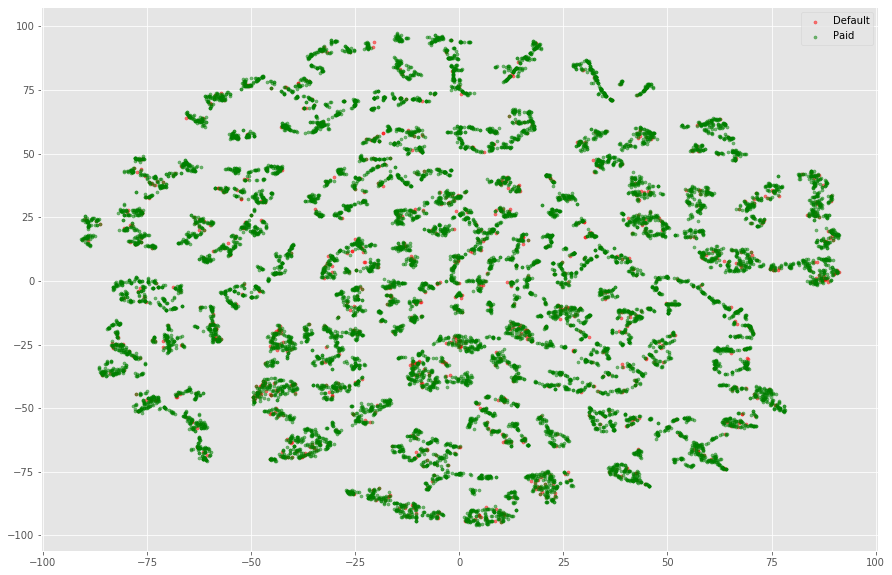

In [14]:
# Visualisation graphique

fig, ax = plt.subplots(figsize=(15,10))
ax.scatter(df_tsne[df_tsne['Class']==1].x.values, df_tsne[df_tsne['Class']==1].y.values,
           c='red', s=10, alpha=0.5, label='Default')
ax.scatter(df_tsne[df_tsne['Class']==0].x.values, df_tsne[df_tsne['Class']==0].y.values,
           c='green', s=10, alpha=0.5, label='Paid')
ax.tick_params(axis='both', which='major', labelsize=10)
ax.legend()
plt.show();

On remarque que les données ne sont pas clairement séparées entre défaut et prêts remboursés. Nous verrons si nous pouvons remédier à cela via différentes techniques

<a id="section2"> </a>
# 2. Définition d'un scoring adapté à problématique métier

Afin de pouvoir évaluer notre modèle, il convient de trouver la mesure la plus pertinente pour notre besoin métier.  

Etant une banque, outre la bonne détection des prêts accordés ou refusés correctement (True Negative ou True Positives), il nous faut aussi minimiser autant que possible les cas où un emprunteur serait identifié comme solvable alors qu'il ne l'est pas (False Negative).

Il est moins crucial de se concentrer sur les emprunteurs identifiés comme insolvables alors qu'ils le sont, même si cela a aussi un coût pour la banque (d'opportunité, en premier lieu, mais aussi potentiellement réputationnel).

Minimiser les FN revient donc à maximiser la mesure de Recall par rapport à celle de Precision.

Pour ce faire, je vais utiliser la mesure dite 'F2-measure', qui est une application de la mesure Fbeta avec un beta de 2 (qui a pour effet d'augmenter l'important du Recall)  
  
beta = Cost of False Negative/Cost of False Positive

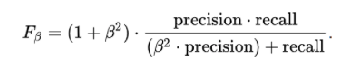

In [15]:
import cv2

img = cv2.imread("Fbeta.png")
plt.figure(figsize=(6, 6))
plt.grid(None)
plt.axis('off')
plt.imshow(img)

In [16]:
# Fonction de cross validation de score personalisée qui renvoie aussi proba d'appartenir à classe 1

def cv_score(clf, x, y, cv=5, beta = 2, resampling = None):
    cv_score = []
    y_pred_proba = []

    # creation de folds pour CV
    kf = StratifiedKFold(n_splits=cv, shuffle = False)
    
    for train_indices, valid_indices in kf.split(x,y):
        # Entrainement pour le fold considéré
        xtrn, ytrn = x.iloc[train_indices], y.iloc[train_indices]
        # Validation
        xval, yval = x.iloc[valid_indices], y.iloc[valid_indices]

        # Entraînement en fonction de rebalancing ou pas
        if resampling is not None :
            # Resample train set
            xtrn_rs, ytrn_rs = resampling.fit_resample(xtrn, ytrn)
            clf.fit(xtrn_rs, ytrn_rs)
        else:
            clf.fit(xtrn, ytrn)

        # Prédiction sur jeu de test
        ypred = clf.predict(xval)
        
        # Sauvegarde des probas pour la classe 1
        yprob = clf.predict_proba(xval)
        y_pred_proba+=(list(yprob[:,1]))

        # Enregistrement des scores
        score = round(fbeta_score(yval, ypred, beta = beta),3)
        
        cv_score.append(score)
    
    return np.array(cv_score), np.array(y_pred_proba)


<a id="section3"> </a>
# 3. Comparaison de plusieurs Classifiers et definition de fonctions

Je vais commencer par tester une série de Classifiers en utilisant leurs paramètres standards avec cross validation sur la métrique de score présentée ci-dessus pour ne retenir que les 3 plus performants

In [17]:
# Ajustement des noms de colonnes pour algorithme LGBM

import re
Xtrain = Xtrain.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))
Xtest = Xtest.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))

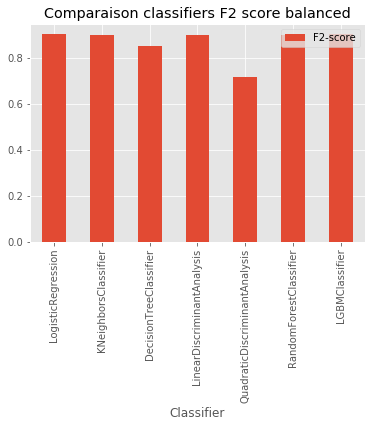

In [18]:
# Comparaison de 7 algorithmes de classification

classifiers = [LogisticRegression(), 
               KNeighborsClassifier(), 
               DecisionTreeClassifier(),
               LinearDiscriminantAnalysis(),
               QuadraticDiscriminantAnalysis(),
               RandomForestClassifier(random_state=2),
               lgb.LGBMClassifier()
              ]

# Enregistrement des scores pour comparaison visuelle
log_cols=["Classifier", "F2-score"]
log = pd.DataFrame(columns=log_cols)

# Création d'un scorer pour cross validation du score FBeta et calcul de ces scores pour chaque classifier

scorer_beta = make_scorer(fbeta_score, beta=2, average = 'weighted')

for clf in classifiers:
    F_Beta2_scores = cross_val_score(clf, Xtrain, ytrain, cv=5, scoring=scorer_beta)
    name = clf.__class__.__name__
    log_entry = pd.DataFrame([[name, F_Beta2_scores.mean()]], columns=log_cols)
    log = log.append(log_entry)

log.plot(x="Classifier", y=["F2-score"], kind="bar")
plt.title("Comparaison classifiers F2 score balanced")
plt.show()

Je retiens donc les 3 modèles les plus performants selon la mesure F2 score:

In [19]:
log.nlargest(3,['F2-score'])

,Classifier,F2-score
0,LogisticRegression,0.904397
0,LGBMClassifier,0.904281
0,RandomForestClassifier,0.903871


Ces performances ont permis d'identifier 3 classfiers que je vais tenter d'optimiser en fonction du jeu de données.  
  
Je vais maintenant développer 2 fonctions qui seront utiles lors de l'optimisation de ces 3 modèles

In [20]:
# Creation d'une fonction qui indique le seuil optimal qui maximise le score F2

def threshold_selection(Y_proba, Ytrain):
    
    scores = []
    for threshold in np.linspace(0, 1, num=101):
        y_pred = (Y_proba > threshold)*1
        score = fbeta_score(Ytrain, y_pred, beta = 2)
        scores.append(score) 

    scores = np.asarray(scores)
    best_threshold, best_score = (scores.argmax()*.01, round(scores.max(),3))
    
    print('Best Threshold :', best_threshold)
    print('Best Score :', best_score)

    plt.plot(np.linspace(0, 1, num=101), scores, lw=1)
    plt.axvline(best_threshold, ls='--', lw=1, c='r')
    plt.xlabel('Threshold')
    plt.ylabel('Score performed')
    plt.show()

In [21]:
# Création d'une fonction qui fit le modèle sur les données d'entraînement, fait tourner le modèle sur le jeu 
# de données test, calcule le score F2, et fournit la matrice de confusion

def make_pred(clf, x_train, y_train, x_test, y_test, thresh):
    
    clf.fit(x_train, y_train)
    probas = clf.predict_proba(x_test)[:,1]
    predictions = (probas > thresh)*1
    
    # calcul du F2 score
    score = round(fbeta_score(y_test, predictions, beta = 2),3)
    
    cm=confusion_matrix(y_test, predictions, normalize='true')*100
        
    # Affichage du score et de la confusion matrix
    ax = sns.heatmap(cm, annot=True, cmap='RdBu', center=0, cbar=False)
    ax.set_title('Confusion matrix (%)')
    ax.set_xlabel('Predicted Label')
    ax.set_ylabel('True Label')
    plt.show()
    
    print('Score sur le jeu de données Test avec seuil de {} : {}'.format(thresh, score))

In [22]:
# Création d'un Dataframe pour enregistrer les scores de chaque modèle

log_cols=["Logistic Regression", "Random Forrest", "LGBM"]
indexes = ["Paramètre_Class", "Smote", "Under_Sampling"]
scores_log = pd.DataFrame(index = indexes, columns=log_cols)

Enfin je vais définir une baseline pour notre modèle et calculer plusieurs mesures de performances afin de comparer les optimisations apportées par la suite.

Je choisis un DummyClassifier qui prédit systématiquement la classe minoritaire afin d'avoir un recall maximum et un cv_score considéré comme ma baseline

Best Threshold : 0.0
Best Score : 0.304


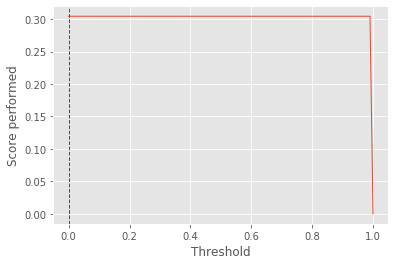

In [23]:
# Définition d'une baseline avec un Dummy Classifier

model = DummyClassifier(strategy='constant', constant=1)

y_proba = cv_score(model,Xtrain, ytrain, cv = 5, beta = 2)[1]

threshold_selection(y_proba, ytrain)


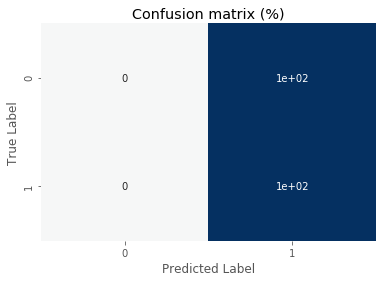

Score sur le jeu de données Test avec seuil de 0 : 0.304
Recall =  1.0
Precision =  0.08
AUC score =  0.5


In [24]:
make_pred(model, Xtrain, ytrain, Xtest, ytest, thresh = 0)

print("Recall = ", round(recall_score(ytest, model.predict(Xtest)),2))
print("Precision = ", round(precision_score(ytest, model.predict(Xtest)),2))
print("AUC score = ", round(roc_auc_score(ytest, model.predict_proba(Xtest)[:, 1]),2))

La baseline à laquelle nous allons comparer les 3 modèle a un score de 0.304

<a id="section4"> </a>
# 4. Optimization des performances - Logistic Regression 

Nous commençons notre analyse avec le modèle Logistic Regression.  
  
Dans un premier temps nous essaierons de remédier à déséquilibre entre les classes en utilisant un paramètre propre au classifier, puis utiliserons deux techniques de resampling, une couvrant la classe minoritaire et l'autre la classe majoritaire.

<a id="section4.1"> </a>
# 4.1 Rebalancing par le paramètre du classifier class_weight = 'balanced' 

Le paramètre "class_weight" est utilisé pour pénaliser différement les erreurs de classifications selon qu'il s'agit de la classe majoritaire ou de la minoritaire. En fixant ce paramètre à 'balanced', le poids appliqué à la pénalité est inversement proportionnel à la fréquence de la classe.

In [25]:
# Je commence par une recherche sur grille des meilleurs paramètres du modèle

clf = LogisticRegression(class_weight = 'balanced')

ftwo_scorer = make_scorer(fbeta_score, beta=2)

# use a full grid over all parameters
grid_values = {'penalty': ['l1','l2'], 'C': [0.001,0.01,0.1,1,10,100,1000]}

# run grid search
grid = GridSearchCV(clf, param_grid=grid_values, cv=5, scoring = ftwo_scorer)
grid.fit(Xtrain, ytrain)

print("Grid-Search with F2-score")
print("Best parameters:", grid.best_params_)
print("Best cross-validation score (F2-score)): {:.3f}".format(grid.best_score_))

Grid-Search with F2-score
Best parameters: {'C': 0.1, 'penalty': 'l2'}
Best cross-validation score (F2-score)): 0.402


Best Threshold : 0.48
Best Score : 0.391


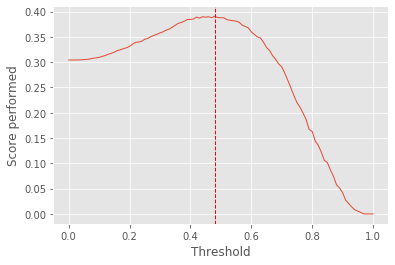

In [26]:
# Optimisation du seuil en application la fonction au modèle optimisé à l'étape précédente

clf_reg_bal = LogisticRegression(C = 0.1,
                        penalty = 'l2',
                        class_weight = 'balanced')

y_proba = cv_score(clf_reg_bal,Xtrain, ytrain, cv = 5, beta = 2)[1]

threshold_selection(y_proba, ytrain)

Maintenant que nous avons les meilleurs paramètres pour le modèle, nous pouvons optimiser la performance du modèle en jouant sur la valeur du seuil ('Threshold') à partir duquel on décide de l'appartenance à la classe 1

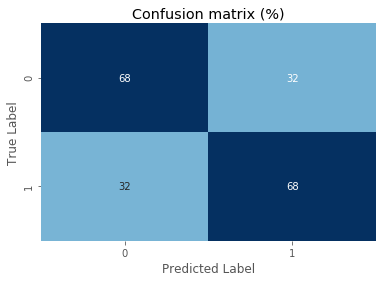

Score sur le jeu de données Test avec seuil de 0.48 : 0.407
Recall =  0.65
Precision =  0.16
AUC score =  0.75


In [27]:
# Prévisions sur jeu de données test en utilisant modèle optimisé précédemment

make_pred(clf_reg_bal, Xtrain, ytrain, Xtest, ytest, thresh = 0.48)

print("Recall = ", round(recall_score(ytest, clf_reg_bal.predict(Xtest)),2))
print("Precision = ", round(precision_score(ytest, clf_reg_bal.predict(Xtest)),2))
print("AUC score = ", round(roc_auc_score(ytest, clf_reg_bal.predict_proba(Xtest)[:, 1]),2))

Le score est supérieur à la baseline. Le modèle identifie correctement 68% des personnes solvables et 68% des personnes faisant défaut, avec un recall de 65%. Le % de Faux Négatifs (TypeII Error) est toutefois assez élevé à 32%.

In [28]:
scores_log.loc["Paramètre_Class", "Logistic Regression"] = 0.407

<a id="section4.2"> </a>
# 4.2 Rebalancing par oversampling de la classe minoritaire (SMOTE)



Synthetic Minority Oversampling Technique (SMOTE) crée artificiellement des observations additionnelles dans la classe minoritaire (ici TARGET = 1) afin de rééquilibrer la distribution de la variable.

SMOTE choisit aléatoirement une instance a de la classe minoritaire et cherche ses k plus proches voisins (ici, k=5). Une instance b est alors créée en choisissant aléatoirement parmi ces k voisins, puis connectée à l'instance a pour créer un segment dans l'espace des feautres. Les autres instances synthétiques sont générées par une combinaisons convexe des 2 instances a et b.

In [29]:
# Application de l'oversampling appliqué au jeu de données d'entraînement

smote = SMOTE(random_state=2)
Xsmot, ysmot = smote.fit_resample(Xtrain, ytrain)

In [30]:
# On remarque l'équilibre entre les classes 0 et 1 post oversampling

print(Counter(ytrain))
print(Counter(ysmot))

Counter({0.0: 10345, 1.0: 905})
Counter({0.0: 10345, 1.0: 10345})


In [31]:
# Visualisation T-SNE post SMOTE

matrix_2d = tsne.fit_transform(Xsmot)

colors = ['G' if i==0 else 'R' for i in ysmot]

df_tsne = pd.DataFrame(matrix_2d)
df_tsne['Class'] = pd.DataFrame(ysmot)["TARGET"].values
df_tsne['color'] = colors
df_tsne.columns = ['x','y','Class','color']
cols = ['Class','color','x','y']
df_tsne = df_tsne[cols]

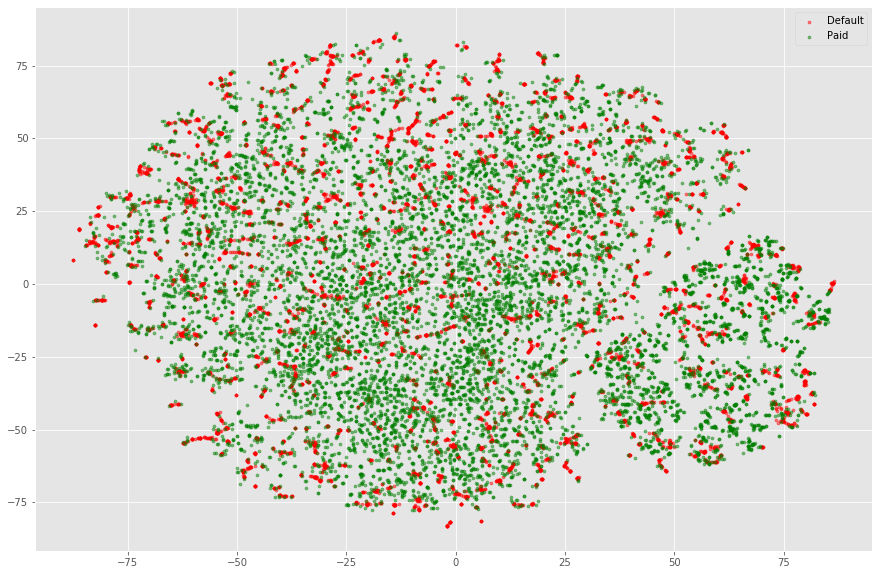

In [32]:
# Visualisation

fig, ax = plt.subplots(figsize=(15,10))
ax.scatter(df_tsne[df_tsne['Class']==1].x.values, df_tsne[df_tsne['Class']==1].y.values,
           c='red', s=10, alpha=0.5, label='Default')
ax.scatter(df_tsne[df_tsne['Class']==0].x.values, df_tsne[df_tsne['Class']==0].y.values,
           c='green', s=10, alpha=0.5, label='Paid')
ax.tick_params(axis='both', which='major', labelsize=10)
ax.legend()
plt.show();

L'utilisation de Smote n'a pas amélioré la situation en termes de séparabilité des données

In [33]:
# Je commence par une recherche sur grille des meilleurs paramètres du modèle

clf = LogisticRegression()

ftwo_scorer = make_scorer(fbeta_score, beta=2)

# use a full grid over all parameters
grid_values = {'penalty': ['l1','l2'], 'C': [0.001,0.01,0.1,1,10,100,1000]}

# run grid search
grid = GridSearchCV(clf, param_grid=grid_values, cv=5, scoring = ftwo_scorer)
grid.fit(Xtrain, ytrain)

print("Grid-Search with F2-score")
print("Best parameters:", grid.best_params_)
print("Best cross-validation score (F2-score)): {:.3f}".format(grid.best_score_))

Grid-Search with F2-score
Best parameters: {'C': 10, 'penalty': 'l2'}
Best cross-validation score (F2-score)): 0.038


Best Threshold : 0.42
Best Score : 0.376


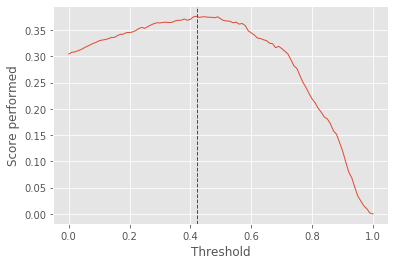

In [34]:
# Optimisation du seuil en application la fonction au modèle optimisé à l'étape précédente

clf_reg = LogisticRegression(C = 10,
                        penalty = 'l2')

y_proba = cv_score(clf_reg,Xtrain, ytrain, cv = 5, beta = 2, resampling = smote)[1]

threshold_selection(y_proba, ytrain)

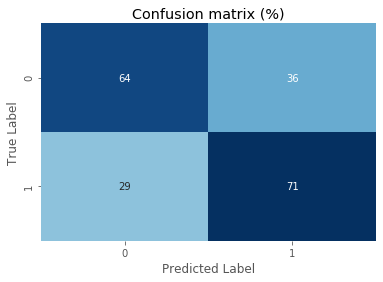

Score sur le jeu de données Test avec seuil de 0.42 : 0.403
Recall =  0.62
Precision =  0.16
AUC score =  0.74


In [35]:
# Prévisions sur jeu de données test en utilisant modèle optimisé précédemment

make_pred(clf_reg, Xsmot, ysmot, Xtest, ytest, thresh = 0.42)

print("Recall = ", round(recall_score(ytest, clf_reg.predict(Xtest)),2))
print("Precision = ", round(precision_score(ytest, clf_reg.predict(Xtest)),2))
print("AUC score = ", round(roc_auc_score(ytest, clf_reg.predict_proba(Xtest)[:, 1]),2))

Le modèle a un score très légèrement inférieur mais reste meilleur par rapport à la baseline. Il identifie correctement 64% des personnes solvables et 71% des personnes faisant défaut, avec un recall en baisse à 62%. Les erreurs de Type II sont aussi légèrement en baisse avec 29% de Faux Négatifs.

In [36]:
scores_log.loc["Smote", "Logistic Regression"] = 0.403

<a id="section4.3"> </a>
# 4.3 Rebalancing par undersampling de la classe majoritaire

Contrairement à la méthode précédente qui conste à créer synthétiquement des données pour la classe minoritaire, la méthode d'undersampling permet de réduire des données de la classe majoritaire.  
  
Plutôt que de choisir une méthode basée sur une suppression aléatoire, je choisis la méthode Near Miss dans sa version 3 qui ne conserve que les éléments de la classe majoritaire qui ont une distance minimum avec chacun des éléments de la classe minoritaire.

In [37]:
under_sampler = NearMiss(version=3)
x_resamp, y_resamp = under_sampler.fit_resample(Xtrain, ytrain)

print(Counter(ytrain))
print(Counter(y_resamp))

Counter({0.0: 10345, 1.0: 905})
Counter({0.0: 905, 1.0: 905})


In [38]:
# Visualisation T-SNE post Undersampling

matrix_2d = tsne.fit_transform(x_resamp)

colors = ['G' if i==0 else 'R' for i in y_resamp]

df_tsne = pd.DataFrame(matrix_2d)
df_tsne['Class'] = pd.DataFrame(y_resamp)["TARGET"].values
df_tsne['color'] = colors
df_tsne.columns = ['x','y','Class','color']
cols = ['Class','color','x','y']
df_tsne = df_tsne[cols]

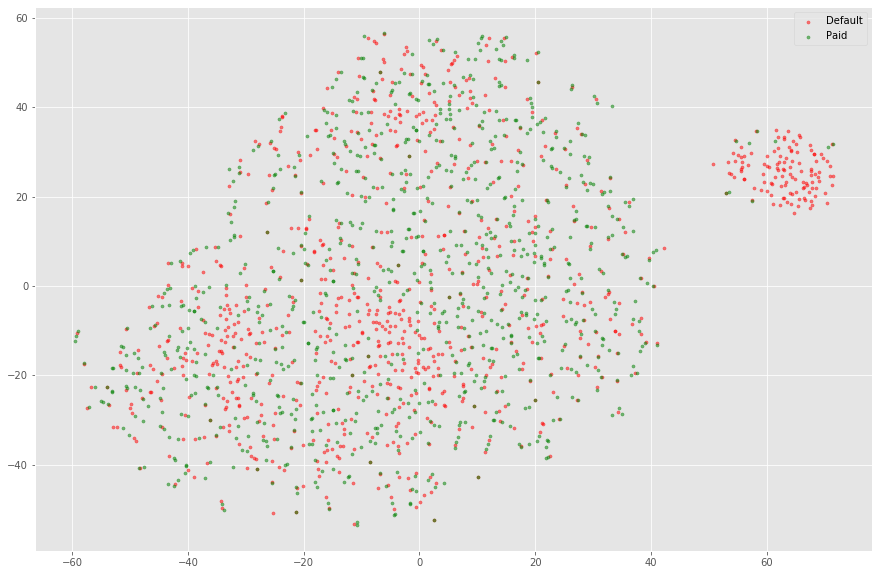

In [39]:
fig, ax = plt.subplots(figsize=(15,10))
ax.scatter(df_tsne[df_tsne['Class']==1].x.values, df_tsne[df_tsne['Class']==1].y.values,
           c='red', s=10, alpha=0.5, label='Default')
ax.scatter(df_tsne[df_tsne['Class']==0].x.values, df_tsne[df_tsne['Class']==0].y.values,
           c='green', s=10, alpha=0.5, label='Paid')
ax.tick_params(axis='both', which='major', labelsize=10)
ax.legend()
plt.show();

Ici il semblerait que la méthode d'UnderSampling choisie permette d'obtenir des données légèrement mieux séparables

Best Threshold : 0.34
Best Score : 0.349


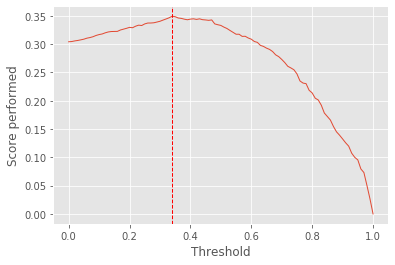

In [40]:
# Optimisation du seuil en application la fonction au modèle optimisé après recherche sur grille

y_proba_unders = cv_score(clf_reg,Xtrain, ytrain, cv = 5, beta = 2, resampling = under_sampler)[1]

threshold_selection(y_proba_unders, ytrain)

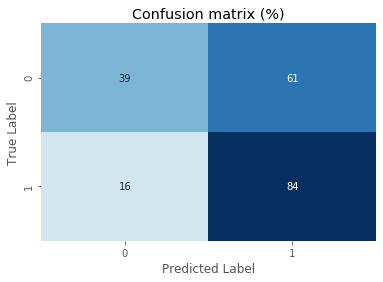

Score sur le jeu de données Test avec seuil de 0.34 : 0.354
Recall =  0.66
Precision =  0.12
AUC score =  0.64


In [41]:
# Prévisions sur jeu de données test en utilisant modèle optimisé précédemment

make_pred(clf_reg, x_resamp, y_resamp, Xtest, ytest, thresh = 0.34)

print("Recall = ", round(recall_score(ytest, clf_reg.predict(Xtest)),2))
print("Precision = ", round(precision_score(ytest, clf_reg.predict(Xtest)),2))
print("AUC score = ", round(roc_auc_score(ytest, clf_reg.predict_proba(Xtest)[:, 1]),2))

Le modèle a le moins bon score car il identifie mal les personnes n'ayant pas fait défaut et notamment, surestime les personnes identifiée comme ayant fait défaut alors qu'elles sont solvables (Faux Positifs). C'est toutefois le meilleur Recall avec 66% grâce au faible nombre d'erreurs de Type II (Faux Negatifs)

In [42]:
scores_log.loc["Under_Sampling", "Logistic Regression"] = 0.354

<a id="section5"> </a>
# 5. Optimization des performances - Random Forest Classifier

Nous passons désormais au modèle de classification basé sur les Random Forest.  
  
Nous suivrons la même méthode pour tenter de résoudre les problèmes liés au déséquilibre entre les classes de clients.

<a id="section5.1"> </a>
# 5.1 Rebalancing par le paramètre du classifier class_weight = 'balanced' 

In [43]:
# Recherche sur grille des meilleurs paramètres du modèle

clf = RandomForestClassifier(random_state=2,
                             class_weight = 'balanced')


param_grid = {'n_estimators' : [50,100,150], 
              'max_depth': [3, 5, None],
              'max_features': [1, 3, 10],
              'min_samples_split': [2, 3, 10],
             'min_samples_leaf' : [1, 16, 64]}

ftwo_scorer = make_scorer(fbeta_score, beta=2)

# run grid search
grid = RandomizedSearchCV(clf, param_grid, cv=5,scoring=ftwo_scorer,n_iter = 10)

grid.fit(Xtrain, ytrain)

print("Grid-Search with F2-score")
print("Best parameters:", grid.best_params_)
print("Best cross-validation score (F2-score)): {:.3f}".format(grid.best_score_))

Grid-Search with F2-score
Best parameters: {'n_estimators': 150, 'min_samples_split': 10, 'min_samples_leaf': 64, 'max_features': 3, 'max_depth': 5}
Best cross-validation score (F2-score)): 0.378


Best Threshold : 0.49
Best Score : 0.37


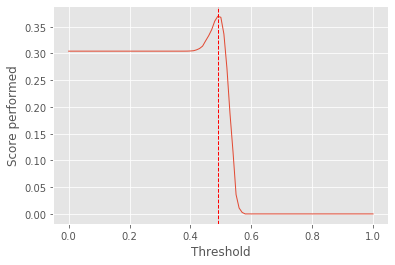

In [44]:
# Optimisation du seuil en application la fonction au modèle optimisé à l'étape précédente

clf_rf_bal = RandomForestClassifier(random_state=2,
                                    class_weight = 'balanced',
                                    n_estimators = 150,
                                    max_depth = 5,
                                    max_features = 3,
                                    min_samples_split = 10,
                                    min_samples_leaf = 64)

y_proba = cv_score(clf_rf_bal,Xtrain, ytrain, cv = 5, beta = 2)[1]

threshold_selection(y_proba, ytrain)

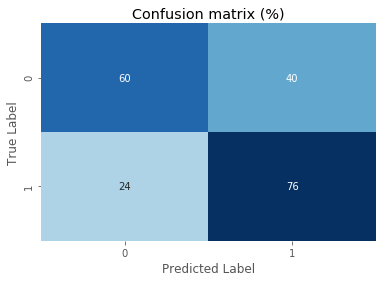

Score sur le jeu de données Test avec seuil de 0.49 : 0.41
Recall =  0.64
Precision =  0.16
AUC score =  0.74


In [45]:
# Prévisions sur jeu de données test en utilisant modèle optimisé précédemment

make_pred(clf_rf_bal, Xtrain, ytrain, Xtest, ytest, thresh = 0.49)

print("Recall = ", round(recall_score(ytest, clf_rf_bal.predict(Xtest)),2))
print("Precision = ", round(precision_score(ytest, clf_rf_bal.predict(Xtest)),2))
print("AUC score = ", round(roc_auc_score(ytest, clf_rf_bal.predict_proba(Xtest)[:, 1]),2))

Le modèle a un bon score de 0.41. Il identifie correctement 60% des personnes solvables et 76% des personnes faisant défaut, avec un recall plus faible que le modèle précédent à 64%.

In [46]:
scores_log.loc["Paramètre_Class", "Random Forrest"] = 0.41

<a id="section5.2"> </a>
# 5.2 Rebalancing par oversampling de la classe minoritaire SMOTE

In [51]:
clf = RandomForestClassifier(random_state=2)


param_grid = {'n_estimators' : [50,100,150], 
              'max_depth': [3, 5,10, None],
              'max_features': [1, 3, 10],
              'min_samples_split': [2, 3, 10],
             'min_samples_leaf' : [1, 16, 64]}

ftwo_scorer = make_scorer(fbeta_score, beta=2)

# run grid search
grid = RandomizedSearchCV(clf, param_grid, cv=5,scoring=ftwo_scorer,n_iter = 10)

grid.fit(Xtrain, ytrain)

print("Grid-Search with F2-score")
print("Best parameters:", grid.best_params_)
print("Best cross-validation score (F2-score)): {:.3f}".format(grid.best_score_))

Grid-Search with F2-score
Best parameters: {'n_estimators': 100, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 10, 'max_depth': 3}
Best cross-validation score (F2-score)): 0.000


Best Threshold : 0.43
Best Score : 0.346


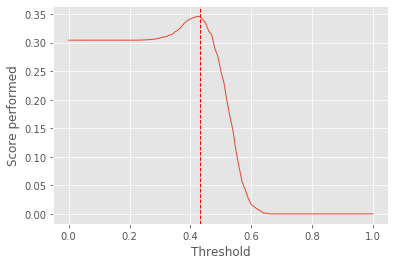

In [52]:
# Optimisation du seuil en application la fonction au modèle optimisé à l'étape précédente

clf_rf = RandomForestClassifier(random_state=2,
                                n_estimators = 100,
                                max_depth = 3,
                                max_features = 10,
                                min_samples_split = 2,
                                min_samples_leaf = 1)

y_proba = cv_score(clf_rf,Xtrain, ytrain, cv = 5, beta = 2, resampling = smote)[1]

threshold_selection(y_proba, ytrain)

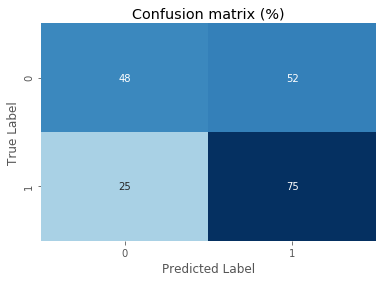

Score sur le jeu de données Test avec seuil de 0.43 : 0.354
Recall =  0.38
Precision =  0.17
AUC score =  0.67


In [53]:
# Prévisions sur jeu de données test en utilisant modèle optimisé précédemment

make_pred(clf_rf, Xsmot, ysmot, Xtest, ytest, thresh = 0.43)

print("Recall = ", round(recall_score(ytest, clf_rf.predict(Xtest)),2))
print("Precision = ", round(precision_score(ytest, clf_rf.predict(Xtest)),2))
print("AUC score = ", round(roc_auc_score(ytest, clf_rf.predict_proba(Xtest)[:, 1]),2))

Le modèle souffre ici du déséquilibre et la méthode Smote dégrade le score. Le modèle a de très mauvais résultat avec la classe Négative. A noter le faible nombre d'erreurs de Type II, ainsi qu'un recall qui chute à 38%.

In [54]:
scores_log.loc["Smote","Random Forrest"] = 0.354

<a id="section5.3"> </a>
# 5.3 Rebalancing par undersampling de la classe majoritaire

Best Threshold : 0.47000000000000003
Best Score : 0.35


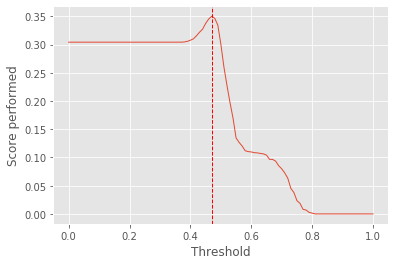

In [55]:
# Optimisation du seuil en application la fonction au modèle optimisé après recherche sur grille

y_proba_unders = cv_score(clf_rf,Xtrain, ytrain, cv = 5, beta = 2, resampling = under_sampler)[1]

threshold_selection(y_proba_unders, ytrain)

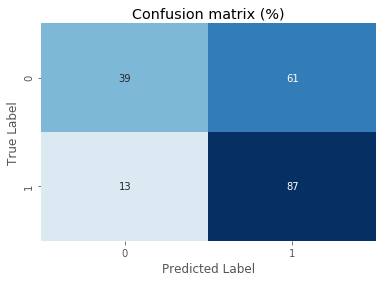

Score sur le jeu de données Test avec seuil de 0.47 : 0.366
Recall =  0.53
Precision =  0.12
AUC score =  0.64


In [56]:
# Prévisions sur jeu de données test en utilisant modèle optimisé précédemment

make_pred(clf_rf, x_resamp, y_resamp, Xtest, ytest, thresh = 0.47)

print("Recall = ", round(recall_score(ytest, clf_rf.predict(Xtest)),2))
print("Precision = ", round(precision_score(ytest, clf_rf.predict(Xtest)),2))
print("AUC score = ", round(roc_auc_score(ytest, clf_rf.predict_proba(Xtest)[:, 1]),2))

Le score reste faible même si légèrement supérieur à Smote.  Le nombre de FN est très bas à 13% mais le modèle fait un très mauvais travail avec les clients ayant remboursé leur prêt. Le recall reste bas à 53%.

In [57]:
scores_log.loc["Under_Sampling", "Random Forrest"] = 0.366

<a id="section6"> </a>
# 6. Optimization des performances - LGBM Classifier

Enfin, je vais utiliser un classifier qui se base sur les techniques de Gradient Boosting qui font partie des méthodes ensemblistes construites sur des arbres de décision et optimisant une fonction de perte à l'aide de descente de gradient.  
  
A nouveau, les 3 mêmes approches que précédemment seront utilisées pour gérer le déséquilibre de classe.

<a id="section6.1"> </a>
# 6.1 Rebalancing par le paramètre du classifier class_weight = 'balanced' 

In [61]:
# Recherche sur grille des meilleurs paramètres du modèle

lgbc = lgb.LGBMClassifier(random_state=2,
                          class_weight = 'balanced')

param_grid = {'objective' : ['binary'],
              'boosting' : ['gbdt', 'dart', 'goss'],
              'n_estimators': [250, 500, 750], 
              'learning_rate' : [0.005, 0.01],
              'max_depth' : [5, 10, 20, None],
              'num_leaves' : [4, 16, 64, 128],
              'min_data_in_leaf' : [100, 500], 
              'reg_alpha' : [1,1.2, 1.4],
              'reg_lambda' : [1,1.2,1.4]}

ftwo_scorer = make_scorer(fbeta_score, beta=2)

grid = RandomizedSearchCV(lgbc, param_grid, n_iter = 50, cv = 5, scoring = ftwo_scorer, verbose=500)

grid.fit(Xtrain, ytrain)

print("Grid-Search with F2-score")
print("Best parameters:", grid.best_params_)
print("Best cross-validation score (F2-score)): {:.3f}".format(grid.best_score_))

Fitting 5 folds for each of 50 candidates, totalling 250 fits
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[CV] reg_lambda=1.2, reg_alpha=1.2, objective=binary, num_leaves=16, n_estimators=250, min_data_in_leaf=100, max_depth=20, learning_rate=0.005, boosting=gbdt 
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[CV]  reg_lambda=1.2, reg_alpha=1.2, objective=binary, num_leaves=16, n_estimators=250, min_data_in_leaf=100, max_depth=20, learning_rate=0.005, boosting=gbdt, score=0.407, total=   0.7s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.7s remaining:    0.0s
[CV] reg_lambda=1.2, reg_alpha=1.2, objective=binary, num_leaves=16, n_estimators=250, min_data_in_leaf=100, max_depth=20, learning_rate=0.005, boosting=gbdt 
[LightGBM] [Warning] min_data_in_leaf is

[CV]  reg_lambda=1.4, reg_alpha=1.4, objective=binary, num_leaves=64, n_estimators=500, min_data_in_leaf=500, max_depth=10, learning_rate=0.01, boosting=dart, score=0.370, total=   3.3s
[Parallel(n_jobs=1)]: Done  13 out of  13 | elapsed:   17.4s remaining:    0.0s
[CV] reg_lambda=1.4, reg_alpha=1.4, objective=binary, num_leaves=64, n_estimators=500, min_data_in_leaf=500, max_depth=10, learning_rate=0.01, boosting=dart 
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
[CV]  reg_lambda=1.4, reg_alpha=1.4, objective=binary, num_leaves=64, n_estimators=500, min_data_in_leaf=500, max_depth=10, learning_rate=0.01, boosting=dart, score=0.359, total=   3.2s
[Parallel(n_jobs=1)]: Done  14 out of  14 | elapsed:   20.6s remaining:    0.0s
[CV] reg_lambda=1.4, reg_alpha=1.4, objective=binary, num_leaves=64, n_estimat

[CV]  reg_lambda=1.2, reg_alpha=1, objective=binary, num_leaves=16, n_estimators=750, min_data_in_leaf=100, max_depth=10, learning_rate=0.005, boosting=dart, score=0.414, total=   9.7s
[Parallel(n_jobs=1)]: Done  26 out of  26 | elapsed:   49.7s remaining:    0.0s
[CV] reg_lambda=1.2, reg_alpha=1, objective=binary, num_leaves=16, n_estimators=750, min_data_in_leaf=100, max_depth=10, learning_rate=0.005, boosting=dart 
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
[CV]  reg_lambda=1.2, reg_alpha=1, objective=binary, num_leaves=16, n_estimators=750, min_data_in_leaf=100, max_depth=10, learning_rate=0.005, boosting=dart, score=0.386, total=   7.2s
[Parallel(n_jobs=1)]: Done  27 out of  27 | elapsed:   56.9s remaining:    0.0s
[CV] reg_lambda=1.2, reg_alpha=1, objective=binary, num_leaves=16, n_estimators=7

[CV]  reg_lambda=1.4, reg_alpha=1.2, objective=binary, num_leaves=4, n_estimators=250, min_data_in_leaf=100, max_depth=5, learning_rate=0.01, boosting=goss, score=0.370, total=   0.5s
[Parallel(n_jobs=1)]: Done  39 out of  39 | elapsed:  1.5min remaining:    0.0s
[CV] reg_lambda=1.4, reg_alpha=1.2, objective=binary, num_leaves=4, n_estimators=250, min_data_in_leaf=100, max_depth=5, learning_rate=0.01, boosting=goss 
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] boosting is set=goss, boosting_type=gbdt will be ignored. Current value: boosting=goss
[CV]  reg_lambda=1.4, reg_alpha=1.2, objective=binary, num_leaves=4, n_estimators=250, min_data_in_leaf=100, max_depth=5, learning_rate=0.01, boosting=goss, score=0.423, total=   0.5s
[Parallel(n_jobs=1)]: Done  40 out of  40 | elapsed:  1.5min remaining:    0.0s
[CV] reg_lambda=1, reg_alpha=1.2, objective=binary, num_leaves=4, n_estimators=500, 

[CV]  reg_lambda=1, reg_alpha=1, objective=binary, num_leaves=128, n_estimators=500, min_data_in_leaf=100, max_depth=None, learning_rate=0.005, boosting=dart, score=0.377, total=   7.6s
[Parallel(n_jobs=1)]: Done  52 out of  52 | elapsed:  2.0min remaining:    0.0s
[CV] reg_lambda=1, reg_alpha=1, objective=binary, num_leaves=128, n_estimators=500, min_data_in_leaf=100, max_depth=None, learning_rate=0.005, boosting=dart 
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
[CV]  reg_lambda=1, reg_alpha=1, objective=binary, num_leaves=128, n_estimators=500, min_data_in_leaf=100, max_depth=None, learning_rate=0.005, boosting=dart, score=0.370, total=   7.6s
[Parallel(n_jobs=1)]: Done  53 out of  53 | elapsed:  2.1min remaining:    0.0s
[CV] reg_lambda=1, reg_alpha=1, objective=binary, num_leaves=128, n_estimators

[CV]  reg_lambda=1, reg_alpha=1, objective=binary, num_leaves=128, n_estimators=500, min_data_in_leaf=100, max_depth=10, learning_rate=0.005, boosting=gbdt, score=0.386, total=   2.4s
[Parallel(n_jobs=1)]: Done  65 out of  65 | elapsed:  2.7min remaining:    0.0s
[CV] reg_lambda=1.4, reg_alpha=1.2, objective=binary, num_leaves=64, n_estimators=750, min_data_in_leaf=100, max_depth=10, learning_rate=0.005, boosting=goss 
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] boosting is set=goss, boosting_type=gbdt will be ignored. Current value: boosting=goss
[CV]  reg_lambda=1.4, reg_alpha=1.2, objective=binary, num_leaves=64, n_estimators=750, min_data_in_leaf=100, max_depth=10, learning_rate=0.005, boosting=goss, score=0.405, total=   3.0s
[Parallel(n_jobs=1)]: Done  66 out of  66 | elapsed:  2.8min remaining:    0.0s
[CV] reg_lambda=1.4, reg_alpha=1.2, objective=binary, num_leaves=64, n_estimat

[CV]  reg_lambda=1.4, reg_alpha=1, objective=binary, num_leaves=16, n_estimators=750, min_data_in_leaf=500, max_depth=10, learning_rate=0.005, boosting=dart, score=0.374, total=   6.1s
[Parallel(n_jobs=1)]: Done  78 out of  78 | elapsed:  3.4min remaining:    0.0s
[CV] reg_lambda=1.4, reg_alpha=1, objective=binary, num_leaves=16, n_estimators=750, min_data_in_leaf=500, max_depth=10, learning_rate=0.005, boosting=dart 
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
[CV]  reg_lambda=1.4, reg_alpha=1, objective=binary, num_leaves=16, n_estimators=750, min_data_in_leaf=500, max_depth=10, learning_rate=0.005, boosting=dart, score=0.359, total=   6.3s
[Parallel(n_jobs=1)]: Done  79 out of  79 | elapsed:  3.5min remaining:    0.0s
[CV] reg_lambda=1.4, reg_alpha=1, objective=binary, num_leaves=16, n_estimators=7

[CV]  reg_lambda=1.2, reg_alpha=1.2, objective=binary, num_leaves=64, n_estimators=750, min_data_in_leaf=500, max_depth=20, learning_rate=0.005, boosting=dart, score=0.423, total=   6.0s
[Parallel(n_jobs=1)]: Done  91 out of  91 | elapsed:  3.9min remaining:    0.0s
[CV] reg_lambda=1.2, reg_alpha=1.2, objective=binary, num_leaves=64, n_estimators=750, min_data_in_leaf=500, max_depth=20, learning_rate=0.005, boosting=dart 
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
[CV]  reg_lambda=1.2, reg_alpha=1.2, objective=binary, num_leaves=64, n_estimators=750, min_data_in_leaf=500, max_depth=20, learning_rate=0.005, boosting=dart, score=0.389, total=   5.9s
[Parallel(n_jobs=1)]: Done  92 out of  92 | elapsed:  4.0min remaining:    0.0s
[CV] reg_lambda=1.2, reg_alpha=1.2, objective=binary, num_leaves=64, n_esti

[CV]  reg_lambda=1.2, reg_alpha=1.2, objective=binary, num_leaves=128, n_estimators=250, min_data_in_leaf=500, max_depth=20, learning_rate=0.005, boosting=goss, score=0.366, total=   0.5s
[Parallel(n_jobs=1)]: Done 104 out of 104 | elapsed:  4.4min remaining:    0.0s
[CV] reg_lambda=1.2, reg_alpha=1.2, objective=binary, num_leaves=128, n_estimators=250, min_data_in_leaf=500, max_depth=20, learning_rate=0.005, boosting=goss 
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] boosting is set=goss, boosting_type=gbdt will be ignored. Current value: boosting=goss
[CV]  reg_lambda=1.2, reg_alpha=1.2, objective=binary, num_leaves=128, n_estimators=250, min_data_in_leaf=500, max_depth=20, learning_rate=0.005, boosting=goss, score=0.399, total=   0.5s
[Parallel(n_jobs=1)]: Done 105 out of 105 | elapsed:  4.4min remaining:    0.0s
[CV] reg_lambda=1, reg_alpha=1, objective=binary, num_leaves=128, n_esti

[CV]  reg_lambda=1.2, reg_alpha=1.2, objective=binary, num_leaves=16, n_estimators=500, min_data_in_leaf=100, max_depth=5, learning_rate=0.005, boosting=gbdt, score=0.396, total=   1.0s
[Parallel(n_jobs=1)]: Done 117 out of 117 | elapsed:  5.1min remaining:    0.0s
[CV] reg_lambda=1.2, reg_alpha=1.2, objective=binary, num_leaves=16, n_estimators=500, min_data_in_leaf=100, max_depth=5, learning_rate=0.005, boosting=gbdt 
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[CV]  reg_lambda=1.2, reg_alpha=1.2, objective=binary, num_leaves=16, n_estimators=500, min_data_in_leaf=100, max_depth=5, learning_rate=0.005, boosting=gbdt, score=0.355, total=   1.0s
[Parallel(n_jobs=1)]: Done 118 out of 118 | elapsed:  5.1min remaining:    0.0s
[CV] reg_lambda=1.2, reg_alpha=1.2, objective=binary, num_leaves=16, n_estimat

[CV]  reg_lambda=1.2, reg_alpha=1.2, objective=binary, num_leaves=4, n_estimators=500, min_data_in_leaf=100, max_depth=None, learning_rate=0.01, boosting=goss, score=0.426, total=   0.9s
[Parallel(n_jobs=1)]: Done 130 out of 130 | elapsed:  5.3min remaining:    0.0s
[CV] reg_lambda=1, reg_alpha=1, objective=binary, num_leaves=16, n_estimators=750, min_data_in_leaf=100, max_depth=10, learning_rate=0.01, boosting=dart 
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
[CV]  reg_lambda=1, reg_alpha=1, objective=binary, num_leaves=16, n_estimators=750, min_data_in_leaf=100, max_depth=10, learning_rate=0.01, boosting=dart, score=0.426, total=   7.1s
[Parallel(n_jobs=1)]: Done 131 out of 131 | elapsed:  5.4min remaining:    0.0s
[CV] reg_lambda=1, reg_alpha=1, objective=binary, num_leaves=16, n_estimators=750, mi

[CV]  reg_lambda=1.4, reg_alpha=1.2, objective=binary, num_leaves=64, n_estimators=750, min_data_in_leaf=500, max_depth=10, learning_rate=0.005, boosting=goss, score=0.370, total=   1.3s
[Parallel(n_jobs=1)]: Done 143 out of 143 | elapsed:  6.0min remaining:    0.0s
[CV] reg_lambda=1.4, reg_alpha=1.2, objective=binary, num_leaves=64, n_estimators=750, min_data_in_leaf=500, max_depth=10, learning_rate=0.005, boosting=goss 
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] boosting is set=goss, boosting_type=gbdt will be ignored. Current value: boosting=goss
[CV]  reg_lambda=1.4, reg_alpha=1.2, objective=binary, num_leaves=64, n_estimators=750, min_data_in_leaf=500, max_depth=10, learning_rate=0.005, boosting=goss, score=0.370, total=   1.4s
[Parallel(n_jobs=1)]: Done 144 out of 144 | elapsed:  6.0min remaining:    0.0s
[CV] reg_lambda=1.4, reg_alpha=1.2, objective=binary, num_leaves=64, n_esti

[CV]  reg_lambda=1.4, reg_alpha=1, objective=binary, num_leaves=16, n_estimators=250, min_data_in_leaf=500, max_depth=10, learning_rate=0.005, boosting=gbdt, score=0.413, total=   0.5s
[Parallel(n_jobs=1)]: Done 156 out of 156 | elapsed:  6.2min remaining:    0.0s
[CV] reg_lambda=1.4, reg_alpha=1, objective=binary, num_leaves=16, n_estimators=250, min_data_in_leaf=500, max_depth=10, learning_rate=0.005, boosting=gbdt 
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[CV]  reg_lambda=1.4, reg_alpha=1, objective=binary, num_leaves=16, n_estimators=250, min_data_in_leaf=500, max_depth=10, learning_rate=0.005, boosting=gbdt, score=0.391, total=   0.5s
[Parallel(n_jobs=1)]: Done 157 out of 157 | elapsed:  6.2min remaining:    0.0s
[CV] reg_lambda=1.4, reg_alpha=1, objective=binary, num_leaves=16, n_estimators=2

[CV]  reg_lambda=1, reg_alpha=1, objective=binary, num_leaves=16, n_estimators=500, min_data_in_leaf=500, max_depth=10, learning_rate=0.01, boosting=dart, score=0.358, total=   3.3s
[Parallel(n_jobs=1)]: Done 169 out of 169 | elapsed:  6.5min remaining:    0.0s
[CV] reg_lambda=1, reg_alpha=1, objective=binary, num_leaves=16, n_estimators=500, min_data_in_leaf=500, max_depth=10, learning_rate=0.01, boosting=dart 
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
[CV]  reg_lambda=1, reg_alpha=1, objective=binary, num_leaves=16, n_estimators=500, min_data_in_leaf=500, max_depth=10, learning_rate=0.01, boosting=dart, score=0.388, total=   3.3s
[Parallel(n_jobs=1)]: Done 170 out of 170 | elapsed:  6.6min remaining:    0.0s
[CV] reg_lambda=1.2, reg_alpha=1.2, objective=binary, num_leaves=16, n_estimators=500, min

[CV]  reg_lambda=1.4, reg_alpha=1.4, objective=binary, num_leaves=16, n_estimators=750, min_data_in_leaf=100, max_depth=20, learning_rate=0.01, boosting=dart, score=0.396, total=   7.2s
[Parallel(n_jobs=1)]: Done 182 out of 182 | elapsed:  6.9min remaining:    0.0s
[CV] reg_lambda=1.4, reg_alpha=1.4, objective=binary, num_leaves=16, n_estimators=750, min_data_in_leaf=100, max_depth=20, learning_rate=0.01, boosting=dart 
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
[CV]  reg_lambda=1.4, reg_alpha=1.4, objective=binary, num_leaves=16, n_estimators=750, min_data_in_leaf=100, max_depth=20, learning_rate=0.01, boosting=dart, score=0.365, total=   7.2s
[Parallel(n_jobs=1)]: Done 183 out of 183 | elapsed:  7.0min remaining:    0.0s
[CV] reg_lambda=1.4, reg_alpha=1.4, objective=binary, num_leaves=16, n_estimat

[CV]  reg_lambda=1.4, reg_alpha=1.4, objective=binary, num_leaves=64, n_estimators=500, min_data_in_leaf=100, max_depth=10, learning_rate=0.005, boosting=goss, score=0.414, total=   2.1s
[Parallel(n_jobs=1)]: Done 195 out of 195 | elapsed:  7.5min remaining:    0.0s
[CV] reg_lambda=1.2, reg_alpha=1.4, objective=binary, num_leaves=4, n_estimators=250, min_data_in_leaf=500, max_depth=None, learning_rate=0.005, boosting=goss 
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] boosting is set=goss, boosting_type=gbdt will be ignored. Current value: boosting=goss
[CV]  reg_lambda=1.2, reg_alpha=1.4, objective=binary, num_leaves=4, n_estimators=250, min_data_in_leaf=500, max_depth=None, learning_rate=0.005, boosting=goss, score=0.413, total=   0.4s
[Parallel(n_jobs=1)]: Done 196 out of 196 | elapsed:  7.5min remaining:    0.0s
[CV] reg_lambda=1.2, reg_alpha=1.4, objective=binary, num_leaves=4, n_est

[CV]  reg_lambda=1, reg_alpha=1.4, objective=binary, num_leaves=128, n_estimators=750, min_data_in_leaf=100, max_depth=20, learning_rate=0.01, boosting=gbdt, score=0.198, total=   3.8s
[Parallel(n_jobs=1)]: Done 208 out of 208 | elapsed:  7.8min remaining:    0.0s
[CV] reg_lambda=1, reg_alpha=1.4, objective=binary, num_leaves=128, n_estimators=750, min_data_in_leaf=100, max_depth=20, learning_rate=0.01, boosting=gbdt 
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[CV]  reg_lambda=1, reg_alpha=1.4, objective=binary, num_leaves=128, n_estimators=750, min_data_in_leaf=100, max_depth=20, learning_rate=0.01, boosting=gbdt, score=0.307, total=   3.8s
[Parallel(n_jobs=1)]: Done 209 out of 209 | elapsed:  7.8min remaining:    0.0s
[CV] reg_lambda=1, reg_alpha=1.4, objective=binary, num_leaves=128, n_estimators=

[CV]  reg_lambda=1.4, reg_alpha=1.2, objective=binary, num_leaves=64, n_estimators=250, min_data_in_leaf=100, max_depth=20, learning_rate=0.005, boosting=dart, score=0.370, total=   2.7s
[Parallel(n_jobs=1)]: Done 221 out of 221 | elapsed:  8.3min remaining:    0.0s
[CV] reg_lambda=1.4, reg_alpha=1.2, objective=binary, num_leaves=64, n_estimators=250, min_data_in_leaf=100, max_depth=20, learning_rate=0.005, boosting=dart 
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
[CV]  reg_lambda=1.4, reg_alpha=1.2, objective=binary, num_leaves=64, n_estimators=250, min_data_in_leaf=100, max_depth=20, learning_rate=0.005, boosting=dart, score=0.369, total=   2.7s
[Parallel(n_jobs=1)]: Done 222 out of 222 | elapsed:  8.3min remaining:    0.0s
[CV] reg_lambda=1.4, reg_alpha=1.2, objective=binary, num_leaves=64, n_esti

[CV]  reg_lambda=1, reg_alpha=1.4, objective=binary, num_leaves=128, n_estimators=750, min_data_in_leaf=500, max_depth=5, learning_rate=0.01, boosting=gbdt, score=0.381, total=   1.0s
[Parallel(n_jobs=1)]: Done 234 out of 234 | elapsed:  8.6min remaining:    0.0s
[CV] reg_lambda=1, reg_alpha=1.4, objective=binary, num_leaves=128, n_estimators=750, min_data_in_leaf=500, max_depth=5, learning_rate=0.01, boosting=gbdt 
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[CV]  reg_lambda=1, reg_alpha=1.4, objective=binary, num_leaves=128, n_estimators=750, min_data_in_leaf=500, max_depth=5, learning_rate=0.01, boosting=gbdt, score=0.411, total=   1.0s
[Parallel(n_jobs=1)]: Done 235 out of 235 | elapsed:  8.6min remaining:    0.0s
[CV] reg_lambda=1.2, reg_alpha=1.4, objective=binary, num_leaves=4, n_estimators=250

[CV]  reg_lambda=1.4, reg_alpha=1.4, objective=binary, num_leaves=128, n_estimators=750, min_data_in_leaf=100, max_depth=20, learning_rate=0.01, boosting=dart, score=0.362, total=  13.9s
[Parallel(n_jobs=1)]: Done 247 out of 247 | elapsed:  9.2min remaining:    0.0s
[CV] reg_lambda=1.4, reg_alpha=1.4, objective=binary, num_leaves=128, n_estimators=750, min_data_in_leaf=100, max_depth=20, learning_rate=0.01, boosting=dart 
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
[CV]  reg_lambda=1.4, reg_alpha=1.4, objective=binary, num_leaves=128, n_estimators=750, min_data_in_leaf=100, max_depth=20, learning_rate=0.01, boosting=dart, score=0.365, total=  13.2s
[Parallel(n_jobs=1)]: Done 248 out of 248 | elapsed:  9.4min remaining:    0.0s
[CV] reg_lambda=1.4, reg_alpha=1.4, objective=binary, num_leaves=128, n_est

[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] boosting is set=goss, boosting_type=gbdt will be ignored. Current value: boosting=goss
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] boosting is set=goss, boosting_type=gbdt will be ignored. Current value: boosting=goss
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] boosting is set=goss, boosting_type=gbdt will be ignored. Current value: boosting=goss
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] boosting is set=goss, boosting_type=gbdt will be ignored. Current value: boosting=goss
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 w

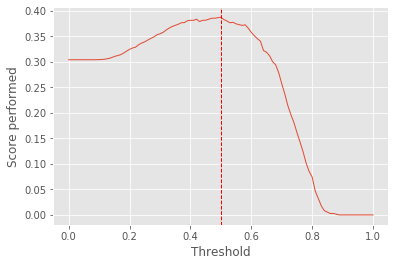

In [64]:
# Optimisation du seuil en application la fonction au modèle optimisé à l'étape précédente

lgbc_bal = lgb.LGBMClassifier(random_state=2,
                              objective = 'binary', 
                              num_leaves = 128, 
                              n_estimators = 500, 
                              min_data_in_leaf = 500, 
                              max_depth = 10, 
                              learning_rate = 0.01, 
                              class_weight = 'balanced', 
                              boosting = 'goss',
                              reg_alpha = 1.4,
                              reg_lambda = 1.4)

y_proba = cv_score(lgbc_bal,Xtrain, ytrain, cv = 5, beta = 2)[1]

threshold_selection(y_proba, ytrain)

[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] boosting is set=goss, boosting_type=gbdt will be ignored. Current value: boosting=goss


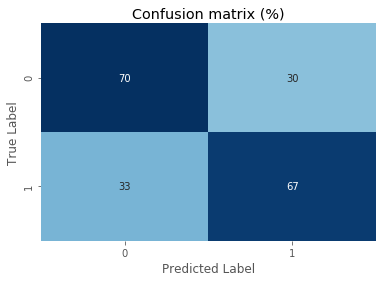

Score sur le jeu de données Test avec seuil de 0.5 : 0.416
Recall =  0.67
Precision =  0.17
AUC score =  0.75


In [65]:
# Prévisions sur jeu de données test en utilisant modèle optimisé précédemment

make_pred(lgbc_bal, Xtrain, ytrain, Xtest, ytest, thresh = 0.5)

print("Recall = ", round(recall_score(ytest, lgbc_bal.predict(Xtest)),2))
print("Precision = ", round(precision_score(ytest, lgbc_bal.predict(Xtest)),2))
print("AUC score = ", round(roc_auc_score(ytest, lgbc_bal.predict_proba(Xtest)[:, 1]),2))

Le score est très bon, c'est le meilleur pour le moment. Le modèle identifie 70% des personnes solvables et 67% des personnes faisant défaut, avec un des recall les plus élevés à 67%.

In [66]:
scores_log.loc["Paramètre_Class", "LGBM"] = 0.416

<a id="section6.2"> </a>
# 6.2 Rebalancing par oversampling de la classe minoritaire

In [67]:
lgbc = lgb.LGBMClassifier(random_state=2)

param_grid = {'objective' : ['binary'],
              'boosting' : ['gbdt', 'dart', 'goss'],
              'n_estimators': [250, 500, 750], 
              'learning_rate' : [0.005, 0.01],
              'max_depth' : [5, 10, 20, None],
              'num_leaves' : [4, 16, 64, 128],
              'min_data_in_leaf' : [50, 100, 500], 
              'reg_alpha' : [1,1.2, 1.4],
              'reg_lambda' : [1,1.2,1.4]}

ftwo_scorer = make_scorer(fbeta_score, beta=2)

grid = RandomizedSearchCV(lgbc, param_grid, n_iter = 40, cv = 5, scoring = ftwo_scorer, verbose=500)

grid.fit(Xtrain, ytrain)

print("Grid-Search with F2-score")
print("Best parameters:", grid.best_params_)
print("Best cross-validation score (F2-score)): {:.3f}".format(grid.best_score_))

Fitting 5 folds for each of 40 candidates, totalling 200 fits
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[CV] reg_lambda=1.4, reg_alpha=1.4, objective=binary, num_leaves=4, n_estimators=500, min_data_in_leaf=500, max_depth=5, learning_rate=0.005, boosting=dart 
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
[CV]  reg_lambda=1.4, reg_alpha=1.4, objective=binary, num_leaves=4, n_estimators=500, min_data_in_leaf=500, max_depth=5, learning_rate=0.005, boosting=dart, score=0.000, total=   1.4s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.4s remaining:    0.0s
[CV] reg_lambda=1.4, reg_alpha=1.4, objective=binary, num_leaves=4, n_estimators=500, min_data_in_leaf=500, max_depth=5, learning_rate=0.005, boosting=dart 
[LightGBM] [Warning] min_data_in_leaf is set=5

[CV]  reg_lambda=1.4, reg_alpha=1.2, objective=binary, num_leaves=16, n_estimators=750, min_data_in_leaf=500, max_depth=20, learning_rate=0.005, boosting=gbdt, score=0.000, total=   1.1s
[Parallel(n_jobs=1)]: Done  13 out of  13 | elapsed:   12.8s remaining:    0.0s
[CV] reg_lambda=1.4, reg_alpha=1.2, objective=binary, num_leaves=16, n_estimators=750, min_data_in_leaf=500, max_depth=20, learning_rate=0.005, boosting=gbdt 
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[CV]  reg_lambda=1.4, reg_alpha=1.2, objective=binary, num_leaves=16, n_estimators=750, min_data_in_leaf=500, max_depth=20, learning_rate=0.005, boosting=gbdt, score=0.000, total=   1.1s
[Parallel(n_jobs=1)]: Done  14 out of  14 | elapsed:   14.0s remaining:    0.0s
[CV] reg_lambda=1.4, reg_alpha=1.2, objective=binary, num_leaves=16, n_esti

[CV]  reg_lambda=1, reg_alpha=1, objective=binary, num_leaves=4, n_estimators=250, min_data_in_leaf=100, max_depth=5, learning_rate=0.005, boosting=goss, score=0.000, total=   0.4s
[Parallel(n_jobs=1)]: Done  26 out of  26 | elapsed:   34.7s remaining:    0.0s
[CV] reg_lambda=1, reg_alpha=1, objective=binary, num_leaves=4, n_estimators=250, min_data_in_leaf=100, max_depth=5, learning_rate=0.005, boosting=goss 
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] boosting is set=goss, boosting_type=gbdt will be ignored. Current value: boosting=goss
[CV]  reg_lambda=1, reg_alpha=1, objective=binary, num_leaves=4, n_estimators=250, min_data_in_leaf=100, max_depth=5, learning_rate=0.005, boosting=goss, score=0.000, total=   0.4s
[Parallel(n_jobs=1)]: Done  27 out of  27 | elapsed:   35.0s remaining:    0.0s
[CV] reg_lambda=1, reg_alpha=1, objective=binary, num_leaves=4, n_estimators=250, min_data_in

[CV]  reg_lambda=1.2, reg_alpha=1, objective=binary, num_leaves=128, n_estimators=500, min_data_in_leaf=50, max_depth=None, learning_rate=0.01, boosting=goss, score=0.021, total=   2.5s
[Parallel(n_jobs=1)]: Done  39 out of  39 | elapsed:  1.3min remaining:    0.0s
[CV] reg_lambda=1.2, reg_alpha=1, objective=binary, num_leaves=128, n_estimators=500, min_data_in_leaf=50, max_depth=None, learning_rate=0.01, boosting=goss 
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Warning] boosting is set=goss, boosting_type=gbdt will be ignored. Current value: boosting=goss
[CV]  reg_lambda=1.2, reg_alpha=1, objective=binary, num_leaves=128, n_estimators=500, min_data_in_leaf=50, max_depth=None, learning_rate=0.01, boosting=goss, score=0.014, total=   2.5s
[Parallel(n_jobs=1)]: Done  40 out of  40 | elapsed:  1.4min remaining:    0.0s
[CV] reg_lambda=1.4, reg_alpha=1.2, objective=binary, num_leaves=16, n_estimator

[CV]  reg_lambda=1, reg_alpha=1.2, objective=binary, num_leaves=128, n_estimators=750, min_data_in_leaf=50, max_depth=None, learning_rate=0.01, boosting=goss, score=0.021, total=   3.5s
[Parallel(n_jobs=1)]: Done  52 out of  52 | elapsed:  1.7min remaining:    0.0s
[CV] reg_lambda=1, reg_alpha=1.2, objective=binary, num_leaves=128, n_estimators=750, min_data_in_leaf=50, max_depth=None, learning_rate=0.01, boosting=goss 
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Warning] boosting is set=goss, boosting_type=gbdt will be ignored. Current value: boosting=goss
[CV]  reg_lambda=1, reg_alpha=1.2, objective=binary, num_leaves=128, n_estimators=750, min_data_in_leaf=50, max_depth=None, learning_rate=0.01, boosting=goss, score=0.014, total=   3.5s
[Parallel(n_jobs=1)]: Done  53 out of  53 | elapsed:  1.8min remaining:    0.0s
[CV] reg_lambda=1, reg_alpha=1.2, objective=binary, num_leaves=128, n_estimators

[CV]  reg_lambda=1.4, reg_alpha=1.4, objective=binary, num_leaves=16, n_estimators=250, min_data_in_leaf=500, max_depth=20, learning_rate=0.01, boosting=goss, score=0.000, total=   0.5s
[Parallel(n_jobs=1)]: Done  65 out of  65 | elapsed:  2.1min remaining:    0.0s
[CV] reg_lambda=1, reg_alpha=1.2, objective=binary, num_leaves=64, n_estimators=500, min_data_in_leaf=100, max_depth=None, learning_rate=0.005, boosting=dart 
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
[CV]  reg_lambda=1, reg_alpha=1.2, objective=binary, num_leaves=64, n_estimators=500, min_data_in_leaf=100, max_depth=None, learning_rate=0.005, boosting=dart, score=0.000, total=   3.3s
[Parallel(n_jobs=1)]: Done  66 out of  66 | elapsed:  2.2min remaining:    0.0s
[CV] reg_lambda=1, reg_alpha=1.2, objective=binary, num_leaves=64, n_estimat

[CV]  reg_lambda=1.4, reg_alpha=1.2, objective=binary, num_leaves=64, n_estimators=250, min_data_in_leaf=500, max_depth=5, learning_rate=0.01, boosting=goss, score=0.000, total=   0.5s
[Parallel(n_jobs=1)]: Done  78 out of  78 | elapsed:  2.7min remaining:    0.0s
[CV] reg_lambda=1.4, reg_alpha=1.2, objective=binary, num_leaves=64, n_estimators=250, min_data_in_leaf=500, max_depth=5, learning_rate=0.01, boosting=goss 
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] boosting is set=goss, boosting_type=gbdt will be ignored. Current value: boosting=goss
[CV]  reg_lambda=1.4, reg_alpha=1.2, objective=binary, num_leaves=64, n_estimators=250, min_data_in_leaf=500, max_depth=5, learning_rate=0.01, boosting=goss, score=0.000, total=   0.5s
[Parallel(n_jobs=1)]: Done  79 out of  79 | elapsed:  2.8min remaining:    0.0s
[CV] reg_lambda=1.4, reg_alpha=1.2, objective=binary, num_leaves=64, n_estimators

[CV]  reg_lambda=1.4, reg_alpha=1.4, objective=binary, num_leaves=4, n_estimators=750, min_data_in_leaf=500, max_depth=5, learning_rate=0.01, boosting=gbdt, score=0.007, total=   0.6s
[Parallel(n_jobs=1)]: Done  91 out of  91 | elapsed:  3.0min remaining:    0.0s
[CV] reg_lambda=1.4, reg_alpha=1.4, objective=binary, num_leaves=4, n_estimators=750, min_data_in_leaf=500, max_depth=5, learning_rate=0.01, boosting=gbdt 
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[CV]  reg_lambda=1.4, reg_alpha=1.4, objective=binary, num_leaves=4, n_estimators=750, min_data_in_leaf=500, max_depth=5, learning_rate=0.01, boosting=gbdt, score=0.007, total=   0.6s
[Parallel(n_jobs=1)]: Done  92 out of  92 | elapsed:  3.0min remaining:    0.0s
[CV] reg_lambda=1.4, reg_alpha=1.4, objective=binary, num_leaves=4, n_estimators=750

[CV]  reg_lambda=1, reg_alpha=1.4, objective=binary, num_leaves=4, n_estimators=500, min_data_in_leaf=100, max_depth=5, learning_rate=0.01, boosting=dart, score=0.000, total=   1.6s
[Parallel(n_jobs=1)]: Done 104 out of 104 | elapsed:  3.2min remaining:    0.0s
[CV] reg_lambda=1, reg_alpha=1.4, objective=binary, num_leaves=4, n_estimators=500, min_data_in_leaf=100, max_depth=5, learning_rate=0.01, boosting=dart 
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
[CV]  reg_lambda=1, reg_alpha=1.4, objective=binary, num_leaves=4, n_estimators=500, min_data_in_leaf=100, max_depth=5, learning_rate=0.01, boosting=dart, score=0.000, total=   1.5s
[Parallel(n_jobs=1)]: Done 105 out of 105 | elapsed:  3.2min remaining:    0.0s
[CV] reg_lambda=1, reg_alpha=1.2, objective=binary, num_leaves=64, n_estimators=750, min_d

[CV]  reg_lambda=1.4, reg_alpha=1.4, objective=binary, num_leaves=64, n_estimators=750, min_data_in_leaf=100, max_depth=10, learning_rate=0.005, boosting=goss, score=0.014, total=   2.6s
[Parallel(n_jobs=1)]: Done 117 out of 117 | elapsed:  3.8min remaining:    0.0s
[CV] reg_lambda=1.4, reg_alpha=1.4, objective=binary, num_leaves=64, n_estimators=750, min_data_in_leaf=100, max_depth=10, learning_rate=0.005, boosting=goss 
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] boosting is set=goss, boosting_type=gbdt will be ignored. Current value: boosting=goss
[CV]  reg_lambda=1.4, reg_alpha=1.4, objective=binary, num_leaves=64, n_estimators=750, min_data_in_leaf=100, max_depth=10, learning_rate=0.005, boosting=goss, score=0.007, total=   2.6s
[Parallel(n_jobs=1)]: Done 118 out of 118 | elapsed:  3.8min remaining:    0.0s
[CV] reg_lambda=1.4, reg_alpha=1.4, objective=binary, num_leaves=64, n_esti

[CV]  reg_lambda=1.2, reg_alpha=1.4, objective=binary, num_leaves=128, n_estimators=250, min_data_in_leaf=50, max_depth=5, learning_rate=0.005, boosting=goss, score=0.000, total=   0.7s
[Parallel(n_jobs=1)]: Done 130 out of 130 | elapsed:  4.2min remaining:    0.0s
[CV] reg_lambda=1.4, reg_alpha=1.4, objective=binary, num_leaves=64, n_estimators=750, min_data_in_leaf=100, max_depth=None, learning_rate=0.01, boosting=goss 
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] boosting is set=goss, boosting_type=gbdt will be ignored. Current value: boosting=goss
[CV]  reg_lambda=1.4, reg_alpha=1.4, objective=binary, num_leaves=64, n_estimators=750, min_data_in_leaf=100, max_depth=None, learning_rate=0.01, boosting=goss, score=0.007, total=   2.5s
[Parallel(n_jobs=1)]: Done 131 out of 131 | elapsed:  4.2min remaining:    0.0s
[CV] reg_lambda=1.4, reg_alpha=1.4, objective=binary, num_leaves=64, n_est

[CV]  reg_lambda=1.2, reg_alpha=1.4, objective=binary, num_leaves=4, n_estimators=250, min_data_in_leaf=500, max_depth=5, learning_rate=0.005, boosting=dart, score=0.000, total=   0.6s
[Parallel(n_jobs=1)]: Done 143 out of 143 | elapsed:  4.5min remaining:    0.0s
[CV] reg_lambda=1.2, reg_alpha=1.4, objective=binary, num_leaves=4, n_estimators=250, min_data_in_leaf=500, max_depth=5, learning_rate=0.005, boosting=dart 
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
[CV]  reg_lambda=1.2, reg_alpha=1.4, objective=binary, num_leaves=4, n_estimators=250, min_data_in_leaf=500, max_depth=5, learning_rate=0.005, boosting=dart, score=0.000, total=   0.6s
[Parallel(n_jobs=1)]: Done 144 out of 144 | elapsed:  4.5min remaining:    0.0s
[CV] reg_lambda=1.2, reg_alpha=1.4, objective=binary, num_leaves=4, n_estimators=

[CV]  reg_lambda=1.2, reg_alpha=1, objective=binary, num_leaves=16, n_estimators=750, min_data_in_leaf=500, max_depth=None, learning_rate=0.005, boosting=goss, score=0.000, total=   1.3s
[Parallel(n_jobs=1)]: Done 156 out of 156 | elapsed:  4.8min remaining:    0.0s
[CV] reg_lambda=1.2, reg_alpha=1, objective=binary, num_leaves=16, n_estimators=750, min_data_in_leaf=500, max_depth=None, learning_rate=0.005, boosting=goss 
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] boosting is set=goss, boosting_type=gbdt will be ignored. Current value: boosting=goss
[CV]  reg_lambda=1.2, reg_alpha=1, objective=binary, num_leaves=16, n_estimators=750, min_data_in_leaf=500, max_depth=None, learning_rate=0.005, boosting=goss, score=0.000, total=   1.3s
[Parallel(n_jobs=1)]: Done 157 out of 157 | elapsed:  4.8min remaining:    0.0s
[CV] reg_lambda=1.2, reg_alpha=1, objective=binary, num_leaves=16, n_estima

[CV]  reg_lambda=1.4, reg_alpha=1.2, objective=binary, num_leaves=128, n_estimators=250, min_data_in_leaf=500, max_depth=None, learning_rate=0.01, boosting=goss, score=0.000, total=   0.8s
[Parallel(n_jobs=1)]: Done 169 out of 169 | elapsed:  5.0min remaining:    0.0s
[CV] reg_lambda=1.4, reg_alpha=1.2, objective=binary, num_leaves=128, n_estimators=250, min_data_in_leaf=500, max_depth=None, learning_rate=0.01, boosting=goss 
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] boosting is set=goss, boosting_type=gbdt will be ignored. Current value: boosting=goss
[CV]  reg_lambda=1.4, reg_alpha=1.2, objective=binary, num_leaves=128, n_estimators=250, min_data_in_leaf=500, max_depth=None, learning_rate=0.01, boosting=goss, score=0.000, total=   0.8s
[Parallel(n_jobs=1)]: Done 170 out of 170 | elapsed:  5.0min remaining:    0.0s
[CV] reg_lambda=1.4, reg_alpha=1.4, objective=binary, num_leaves=64, 

[CV]  reg_lambda=1, reg_alpha=1.4, objective=binary, num_leaves=64, n_estimators=500, min_data_in_leaf=500, max_depth=10, learning_rate=0.01, boosting=dart, score=0.000, total=   2.3s
[Parallel(n_jobs=1)]: Done 182 out of 182 | elapsed:  5.5min remaining:    0.0s
[CV] reg_lambda=1, reg_alpha=1.4, objective=binary, num_leaves=64, n_estimators=500, min_data_in_leaf=500, max_depth=10, learning_rate=0.01, boosting=dart 
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
[CV]  reg_lambda=1, reg_alpha=1.4, objective=binary, num_leaves=64, n_estimators=500, min_data_in_leaf=500, max_depth=10, learning_rate=0.01, boosting=dart, score=0.000, total=   2.6s
[Parallel(n_jobs=1)]: Done 183 out of 183 | elapsed:  5.5min remaining:    0.0s
[CV] reg_lambda=1, reg_alpha=1.4, objective=binary, num_leaves=64, n_estimators=500,

[CV]  reg_lambda=1.2, reg_alpha=1.2, objective=binary, num_leaves=4, n_estimators=500, min_data_in_leaf=500, max_depth=20, learning_rate=0.005, boosting=dart, score=0.000, total=   1.6s
[Parallel(n_jobs=1)]: Done 195 out of 195 | elapsed:  5.8min remaining:    0.0s
[CV] reg_lambda=1.4, reg_alpha=1, objective=binary, num_leaves=4, n_estimators=250, min_data_in_leaf=100, max_depth=5, learning_rate=0.005, boosting=gbdt 
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[CV]  reg_lambda=1.4, reg_alpha=1, objective=binary, num_leaves=4, n_estimators=250, min_data_in_leaf=100, max_depth=5, learning_rate=0.005, boosting=gbdt, score=0.000, total=   0.3s
[Parallel(n_jobs=1)]: Done 196 out of 196 | elapsed:  5.8min remaining:    0.0s
[CV] reg_lambda=1.4, reg_alpha=1, objective=binary, num_leaves=4, n_estimators=250, 

[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] boosting is set=goss, boosting_type=gbdt will be ignored. Current value: boosting=goss
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] boosting is set=goss, boosting_type=gbdt will be ignored. Current value: boosting=goss
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] boosting is set=goss, boosting_type=gbdt will be ignored. Current value: boosting=goss
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] boosting is set=goss, boosting_type=gbdt will be ignored. Current value: boosting=goss
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 w

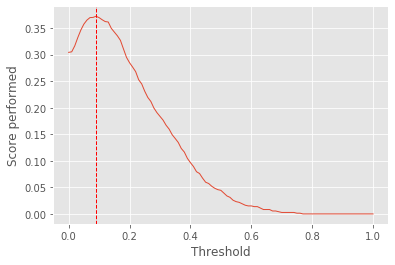

In [69]:
# Optimisation du seuil en application la fonction au modèle optimisé à l'étape précédente

clf_lgbc = lgb.LGBMClassifier(random_state=2, 
                              objective = 'binary', 
                              num_leaves = 64, 
                              n_estimators = 750, 
                              min_data_in_leaf = 100, 
                              max_depth = None, 
                              learning_rate = 0.01, 
                              boosting = 'goss',
                              reg_alpha = 1.4,
                              reg_lambda = 1.4)

y_proba = cv_score(clf_lgbc,Xtrain, ytrain, cv = 5, beta = 2, resampling = smote)[1]

threshold_selection(y_proba, ytrain)

[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] boosting is set=goss, boosting_type=gbdt will be ignored. Current value: boosting=goss


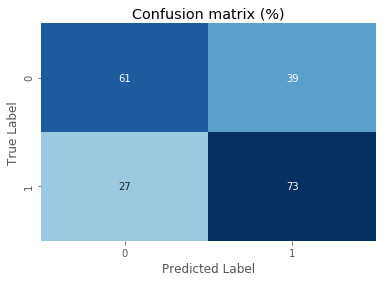

Score sur le jeu de données Test avec seuil de 0.09 : 0.395
Recall =  0.03
Precision =  0.42
AUC score =  0.73


In [70]:
# Prévisions sur jeu de données test en utilisant modèle optimisé précédemment

make_pred(clf_lgbc, Xsmot, ysmot, Xtest, ytest, thresh = 0.09)

print("Recall = ", round(recall_score(ytest, clf_lgbc.predict(Xtest)),2))
print("Precision = ", round(precision_score(ytest, clf_lgbc.predict(Xtest)),2))
print("AUC score = ", round(roc_auc_score(ytest, clf_lgbc.predict_proba(Xtest)[:, 1]),2))

Le score est moins bon que le précédent avec cette méthode mais reste correct. A noter toutefois que le recall est proche de zéro, au profit d'une précision de 42%.

In [71]:
scores_log.loc["Smote","LGBM"] = 0.395

<a id="section6.3"> </a>
# 6.3 Rebalancing par undersampling de la classe majoritaire

[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] boosting is set=goss, boosting_type=gbdt will be ignored. Current value: boosting=goss
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] boosting is set=goss, boosting_type=gbdt will be ignored. Current value: boosting=goss
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] boosting is set=goss, boosting_type=gbdt will be ignored. Current value: boosting=goss
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] boosting is set=goss, boosting_type=gbdt will be ignored. Current value: boosting=goss
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 w

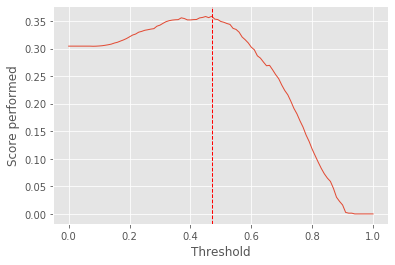

In [72]:
# Optimisation du seuil en application la fonction au modèle optimisé après recherche sur grille

y_proba_unders = cv_score(clf_lgbc,Xtrain, ytrain, cv = 5, beta = 2, resampling = under_sampler)[1]

threshold_selection(y_proba_unders, ytrain)

[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] boosting is set=goss, boosting_type=gbdt will be ignored. Current value: boosting=goss


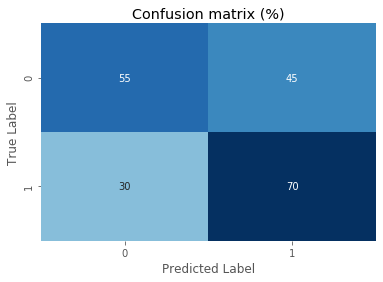

Score sur le jeu de données Test avec seuil de 0.47 : 0.354
Recall =  0.67
Precision =  0.12
AUC score =  0.66


In [73]:
# Prévisions sur jeu de données test en utilisant modèle optimisé précédemment

make_pred(clf_lgbc, x_resamp, y_resamp, Xtest, ytest, thresh = 0.47)

print("Recall = ", round(recall_score(ytest, clf_lgbc.predict(Xtest)),2))
print("Precision = ", round(precision_score(ytest, clf_lgbc.predict(Xtest)),2))
print("AUC score = ", round(roc_auc_score(ytest, clf_lgbc.predict_proba(Xtest)[:, 1]),2))

Le score est encore moins bon même si le recall est l'un des meilleurs. Les erreurs de type II sont à 30%.

In [74]:
scores_log.loc["Under_Sampling", "LGBM"] = 0.354

<a id="section7"> </a>
# 7. Analyse des résultats

In [75]:
scores_log

,Logistic Regression,Random Forrest,LGBM
Paramètre_Class,0.407,0.41,0.416
Smote,0.403,0.354,0.395
Under_Sampling,0.354,0.366,0.354


On remarque que dans les 3 cas, l'utilisation du paramètre class = weighted des classifiers produit les meilleurs scores.

A noter que dans le cadre de la Logistic Regression et dans une moindre mesure, pour le LGBM, la strategie de rebalancing par Smote donne aussi des résultats acceptables.

Enfin, le modèle ayant le meilleur score est le LGBM avec un score de pratiquement 0.42. Ce modèle a obtenu le recall le plus élevé à 67% avec des erreurs de Type I de 30% et des erreurs de Type II de 33% 

Pour rappel, la score de la baseline est de 0.3

<a id="section8"> </a>
# 8. Interprétabilité du modèle

Pour interpréter les résultats des modèles, je vais retenir pour chacun des classifiers celui dont le score est le plus élevé, puis utiliser les deux méthodes suivantes:
- l'étude de l'importance des features principaux (top 10)
- la méthode SHAP basée sur les shapley values

<a id="section8.1"> </a>
## 8.1 Analyse globale du modèle: importance des variables

In [76]:
# Calcul des 10 Features les plus importants pour chaque modèle

lgbc_bal.fit(Xtrain, ytrain)
clf_rf_bal.fit(Xtrain, ytrain)
clf_reg_bal.fit(Xtrain,ytrain)

# Pour le modèle LGBC avec balancing de classe minoritaire par le modèle
lgb_feat_imp = pd.DataFrame(lgbc_bal.feature_importances_, index=X.columns, columns=['Light GBM'])

# Pour le modèle Random Forrest avec balancing de classe minoritaire par le modèle
rf_feat_imp = pd.DataFrame(clf_rf_bal.feature_importances_, index=X.columns, columns=['Random Forest'])

# Pour le modèle Logistic Regression avec balancing de classe minoritaire par le modèle
feature_importance = abs(clf_reg_bal.coef_[0])
sorted_idx = np.argsort(feature_importance)[len(feature_importance) - 10:len(feature_importance)]
pos = np.arange(sorted_idx.shape[0]) + .5

[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] boosting is set=goss, boosting_type=gbdt will be ignored. Current value: boosting=goss


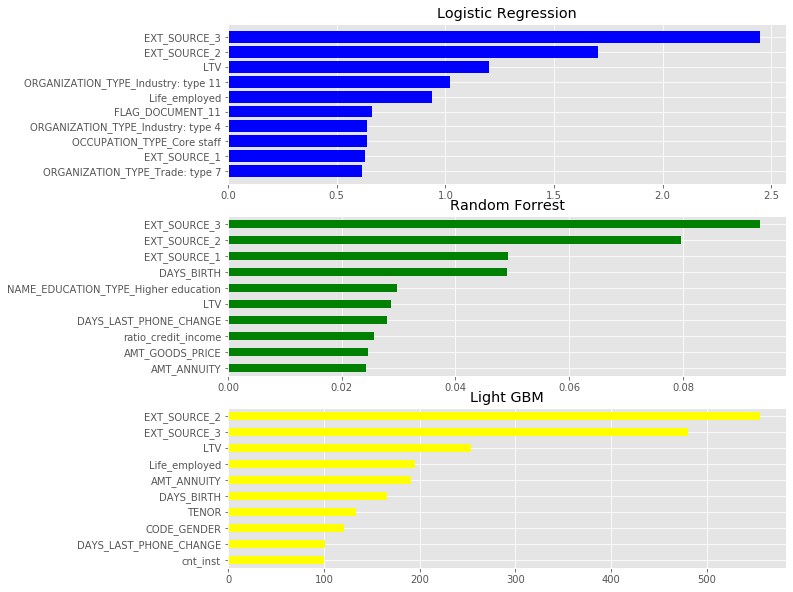

In [77]:
# Représentation graphique de ces features les plus importants pour les 3 modèles

fig, ax = plt.subplots(3, 1, figsize=(10,10) )

ax[0].barh(np.array(X.columns)[sorted_idx], feature_importance[sorted_idx], align='center', color='blue')
rf_feat_imp.sort_values('Random Forest')[-10::].plot.barh(ax=ax[1], color = 'green', legend= None)
lgb_feat_imp.sort_values('Light GBM')[-10::].plot.barh(ax=ax[2], color='yellow', legend=None)

ax[0].set_title('Logistic Regression')
ax[1].set_title('Random Forrest')
ax[2].set_title('Light GBM')

fig.subplots_adjust(wspace=0.5);

**Plusieurs commentaires suite à ces résultats:**  

- on remarque que pour les 3 modèles, les scores attribués par des organismes externes ont le plus d'impact sur les prédictions (le plus frappant étant pour le Random Forrest)
- l'âge est aussi un facteur important
- le feature LTV (rapport entre le prêt et la valeur du bien financé) est aussi un feature important commun aux 3 modèles
- La Logistic Regression, contrairement aux 2 autres modèles, est fortement influencée par le type de société dans laquelle le client travaille
- Random Forrest et Light GBM ont en commun 6 features
- Enfin il est assez surprenant de voir que le nombre de jours depuis le dernier changement de téléphone soit un feature relativement important pour ces 2 modèles
  
  
Toutefois, cette analyse ne permet pas de voir comment un feature donné contribue en terme de prédiction de défaut. Pour cela nous passons à la méthode d'analyse suivante.

In [78]:
# Sauvegarde du modèle ayant eu le meilleur score pour utilisation dans le Dashboard

with open('model.pickle', 'wb') as file :
    pickle.dump(lgbc_bal, file)

<a id="section8.2"> </a>
## 8.2 Analyse locale du modèle: SHAP

SHAP (SHapley Additive exPlanations) est une approche provenant de la théorie des jeux et basée sur les valeurs de Shapley.  
  
L’idée proposée par les auteurs de cette méthode est de calculer la valeur de Shapley pour toutes les variables à chaque exemple du dataset. Cette approche explique la sortie d’un modèle par la somme des effets de chaque variable Xi. L’idée est de moyenner l’impact qu’une variable a pour toutes les combinaisons de variables possibles.


### Préparation du modèle

In [79]:
# Import du module SHAP, initialisation et import du modèle

import shap
shap.initjs()

with open('model.pickle', 'rb') as file : 
    LGB = pickle.load(file)

TreeExplainer, optimisé pour les arbres de décision et ensembles d’arbres, permet de réduire la complexité du modèle SHAP

In [80]:
explainer = shap.TreeExplainer(LGB, 
                               model_output = 'probability',
                               data = Xtrain.sample(200),
                               feature_dependence='independent')

shap_values = explainer.shap_values(Xtest, ytest)

 98%|===================| 3677/3750 [00:38<00:00]        

### Summary Plot

Le Summary Plot est un graph dans lequel les valeurs de Shap sont représentées pour chaque variable dans leur ordre d’importance, chaque point représente une valeur de Shap (pour un exemple), les points rouges représentent des valeurs élevées de la variable et les points bleus des valeurs basses de la variable.

A noter que ce type de représentation permet de voir la densité des différentes valeurs prises pour chaque variable.

Cette méthode confirme globalement l'ordre d'importance des features obtenu précédemment mais information supplémentaire, il permet de voir l'impact de chaque variable sur une prédiction.

Par exemple, on peut voir que plus un score fourni par l'agence de notation 3 est élevée, et plus la valeur de la prédiction sera faible (valeur Shap négative) et donc le client sera en capacité de rembourser son prêt.

Au contraire, plus le montant de l'Annuité est élevé et plus la valeur de la prédiction sera importante, traduisant un client potentiellement en défaut.

Il est aussi intéressant de noter que le modèle indique que le genre du client influence la prédiction et que selon le jeu de données (mais qu'il convient de ne pas généraliser), un code gender élevé (donc de sexe masculin) influencera la prédiction en faveur d'un défaut.

Enfin, pour revenir au cas de la variable "nombre de jours depuis le dernier changement de téléphone" dont les valeurs sont positives, on remarque qu'un client qui a changé récemment de numéro de téléphone a plus de chance de faire défaut. Cela est logique puisqu'un client ayant changé récemment de téléphone est soit un client jeune et donc avec un pouvoir d'achat moindre, soit une personne changeant fréquemment et donc potientiellement moins stable dans ses dépenses.

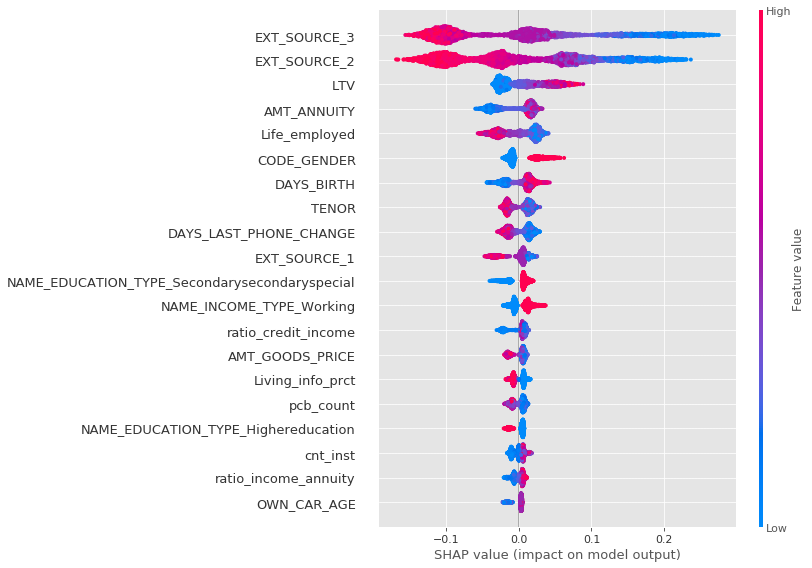

In [81]:
shap.summary_plot(shap_values, Xtest)

### Force Plot

Les diagrammes de type Force Plot ont un intérêt supplémentaire car ils permettent pour chaque prédiction de voir la contribution et l'impact des différents features.

Les features qui apparaissent en rouge sont ceux qui feront augmenter la prédiction (à savoir ici la probabilité de défaut) et inversement, les features en bleu feront baisser la valeur de prédiction et contribueront donc à indiquer un client qui rembourse son prêt.

In [82]:
# Je commence par définir une fonction qui va représenter le diagramme force_plot ainsi que la classe réelle 
# du client, et les probabilités d'appartenance à chacune des classes

def shap_plot(i):
    print(LGB.predict_proba(Xtest.iloc[i:i+1]).round(2))
    print('True class :', ytest.iloc[i])
    return(shap.force_plot(explainer.expected_value, shap_values[i], Xtest.iloc[i]))

In [83]:
# Voyons pour un client une première représentation

shap_plot(3)

[[0.81 0.19]]
True class : 0.0


Ici nous pouvons voir que la prédiction est correcte (individu qui rembourse son prêt).

On remarque immédiatement que les bons scores obtenus auprès des organismes de notation contribuent fortement à une prédiction en faveur d'un remboursement (ce sont les 3 blocs principaux par la taille).

Les valeurs prises par LTV et montant d'annuité contribuent à une hausse toutefois relative de la probabilité de défaut.

In [84]:
# Observation pour un second client

shap_plot(1375)

[[0.75 0.25]]
True class : 0.0


A nouveau une prédiction correcte pour un individu qui rembourse son prêt.

Les scores donnés par les organismes 3 et 1 contribuent à cette prédiction ainsi qu'une LTV moyenne, alors que le score fourni par l'organisme 2 vient relever la valeur de la probabilité de défaut.

In [85]:
# Observation pour un troisième client

shap_plot(475)

[[0.3 0.7]]
True class : 1.0


Nous voyons cette fois un client dont la prédiction est un défaut. Cela est essentiellement dû au faible score donné par les organismes 2 (surtout) et 3, ainsi que par le fait que le client soit de genre masculin.

In [86]:
# Dernier exemple

shap_plot(2001)

[[0.7 0.3]]
True class : 1.0


Enfin il s'agit ici d'une prédiction incorrecte (Faux Positif). Le modèle se base essentiellement sur le score donné par les organismes 3 et 2 et le montant de l'annuité, ce qui semble fausser la prédiction.